# Sinkhorns autoencoder

implementation by @KamilDeja (github) https://github.com/KamilDeja/e2e_sinkhorn_autoencoder/blob/main/MNIST_simple_example.ipynb

In [4]:
run_training = False

Autoencoders are models designed to compress and then reconstruct data. The Sinkhorn Autoencoder uses Sinkhorn algorithm, to make sure that the compressed data (the latent space) keeps the important features and structure of the original data. By using the Sinkhorn algorithm during training, the model creates better and more useful representations of the data, which can lead to higher quality reconstructions and better performance in tasks like grouping similar items, recognizing patterns, and generating new data.

## Sinkhorn autoencoder with noise generator
This Sinkhorn Autoencoder implements a trainable prior approximator dubbed noise generator as a neural network. With such an approach, we can use a gradient obtained from the Sinkhorn loss to simultaneously train the encoder and the noise generator to converge into a similar distribution on the latent space.

![Sinkhorn architecture](sinkhorn_architecture.png)

*The architecture of the Sinkhorn Autoencoder with a neural network as an explicit noise generator. Red arrows indicate the gradient flow. Reconstruction Loss L2 is backpropagated through decoder and encoder, while Sinkhorn loss L1 is propagated in two directions to encoder and noise generator. Encoder network is optimised with a sum of L1 and L2 losses.*

In [5]:
!pip install geomloss

You should consider upgrading via the 'E:\Users\qesterius\Documents\Studia\Wizualizacja_duzych_zbiorow_danych\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Autoencoder definition

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from geomloss import SamplesLoss
import torch

class Autoencoder(nn.Module):
    def __init__(self, g_input_dim, cond_dim):
        super(Autoencoder, self).__init__()
        self.d = 64
        #encoder        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.d)
        self.conv2 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(self.d)
        self.conv3 = nn.Conv2d(self.d, self.d, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(self.d)
        self.fc3 = nn.Linear(self.d*9, self.d//4)
        #latent 16 dim

        #decoder
        self.fc1 = nn.Linear(self.d//4, self.d*4)
        self.dc1 = nn.ConvTranspose2d( self.d, self.d * 4, 4, 2, 0, bias=False)
        self.dc1_bn = nn.BatchNorm2d(self.d*4)
        self.dc2 = nn.ConvTranspose2d( self.d * 4, self.d * 2, 4, 2, 1, bias=False)
        self.dc2_bn = nn.BatchNorm2d(self.d*2)
        self.dc3 = nn.ConvTranspose2d( self.d * 2, self.d , 4, 1, 1, bias=False)
        self.dc3_bn = nn.BatchNorm2d(self.d)
        self.dc4 = nn.ConvTranspose2d( self.d , 1, 4, 2, 0, bias=False)


############        noise_gen
        self.ng_fc1 = nn.Linear(g_input_dim, self.d*2)
        self.ng_input_2 = nn.Linear(cond_dim,self.d)
        self.ng_fc2 = nn.Linear(self.d*3, self.d*4)
        self.ng_fc3 = nn.Linear(self.d*4, self.d*3)
        self.ng_fc4 = nn.Linear(self.d*3, self.d//4)
############

        
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif (classname.find('BatchNorm') != -1):#|(classname.find('Linear') != -1):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    # forward method
    def forward(self, x):
        #encoding
        x = self.conv1(x)
        x = F.leaky_relu(self.bn_1(x))
        x = self.conv2(x)
        x = F.leaky_relu(self.bn_2(x))
        x = self.conv3(x)
        x = F.leaky_relu(self.bn_3(x))
        x = x.view([-1,self.d*9])
        y = self.fc3(x) #latent

        #decoding
        x = F.leaky_relu(self.fc1(y))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x = F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x)), y #reconstruction, latent

    def generate(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1,self.d,2,2)
        x = self.dc1(x)
        x = F.leaky_relu(self.dc1_bn(x))
        x = self.dc2(x)
        x =F.leaky_relu(self.dc2_bn(x))
        x = self.dc3(x)
        x = F.leaky_relu(self.dc3_bn(x))
        return torch.tanh(self.dc4(x))

    def generate_noise(self, x, cond_x): #x is the noise, 
        x = F.leaky_relu(self.ng_fc1(x), 0.2)
        x2 = F.leaky_relu(self.ng_input_2(cond_x), 0.2)
        x_concat = torch.cat((x,x2),1)
        x = F.leaky_relu(self.ng_fc2(x_concat), 0.2)
        x = F.leaky_relu(self.ng_fc3(x), 0.2)
        x = self.ng_fc4(x)
        return x

## FMNIST dataset

In [7]:
!pip install torchvision

You should consider upgrading via the 'E:\Users\qesterius\Documents\Studia\Wizualizacja_duzych_zbiorow_danych\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [8]:
from torchvision.datasets import FashionMNIST

train = FashionMNIST("",download=True,train=True)
test = FashionMNIST("",download=True,train=False)

### Show first 10 images and normalize data

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


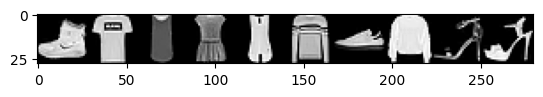

E:\Users\qesterius\AppData\Local\Temp\ipykernel_8844\1270483913.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
E:\Users\qesterius\AppData\Local\Temp\ipykernel_8844\1270483913.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


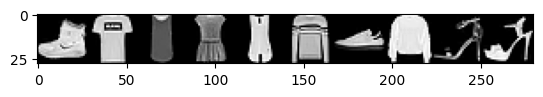

In [9]:
X_train, y_train = train.data, train.targets
X_test, y_test = test.data, test.targets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#show first 10 images
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')
plt.show()

#normalize data
import torch

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')
plt.show()


## Training

In [20]:
!pip install torch torchvision


You should consider upgrading via the 'E:\Users\qesterius\Documents\Studia\Wizualizacja_duzych_zbiorow_danych\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
n_classes = 10
input_size = 28*28
autoencoder = Autoencoder(input_size, n_classes).to(device)

### Sinkhorn loss

It is used in OptimalTransport methods which returns how samples from 1 distribution are distant from another distribution

In this example it is used for noise generator training, so it will try to generate samples from latent distribution

```python
### noise generator losss,
ng_loss = loss_func(
    torch.cat([latent_representation,label_cond_x],1), # actual AE latent output cocated with label
    torch.cat([latent_random,label_cond_x],1) # random generated noise with label concated
    ) 
```

In [12]:
import torch.optim as optim

criterion_mse = nn.MSELoss() #reconstruction loss
loss_func = SamplesLoss("sinkhorn", blur=0.05,scaling = 0.95,diameter=0.01,debias=True)
lr = 0.0001
a_optimizer = optim.Adam(autoencoder.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ExponentialLR(a_optimizer, gamma = 0.95)
batch_size = 64


In [13]:
print(max(y_train), min(y_train))

tensor(9) tensor(0)


In [14]:
print(X_train.shape)
print(y_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [15]:
X_train = torch.Tensor(X_train).view(-1,1,28,28).to(device)
y_train = torch.Tensor(y_train)
y_train = y_train.type(torch.int64).to(device)

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
print("Number of batches: ", len(train_loader))



Number of batches:  937


encoder and decoder are training against each other so reconstruction is most simillar to original

noise generator is trying to generate latent representation which is simillar to what encoder returns

In [16]:
n_epoch = 50
a_weigth = 1000
ng_weigth = 1

if run_training:
    autoencoder.train()
    for epoch in range(1, n_epoch+1):
        ng_losses = []
        a_losses = []
        mse_losses = []
        l2_loss = []
        for batch_idx, (x, label_cond_x) in enumerate(train_loader):
            y_onehot = torch.FloatTensor(batch_size, 10).to(device)
            y_onehot.zero_()

            label_cond_x = y_onehot.scatter_(1, label_cond_x.reshape([-1,1]), 1) #label

            autoencoder.zero_grad()

            autoencoder_output, latent_representation = autoencoder(x)

            ### STANDARD AUTOENCODER MSE loss
            a_loss_mse = criterion_mse(autoencoder_output, x)

            rand_x = torch.rand(batch_size, input_size).to(device) ### Generate input noise for the noise generator
            
            latent_random = autoencoder.generate_noise(rand_x,label_cond_x) ### Generate noise from random vector and conditional params | label is used as conditional params
            #`print(x.shape,y.shape, cond_x.shape, rand_y.shape, cond_x.shape)
            ng_loss = loss_func(torch.cat([latent_representation,label_cond_x],1), torch.cat([latent_random,label_cond_x],1)) ### noise generator losss,
            #conditional params added to compute also loss for generating noise close to this from other conditionals

            s_loss = ng_weigth*ng_loss+ a_weigth*a_loss_mse
            s_loss.backward()

            a_optimizer.step()
            a_losses.append(a_loss_mse)
            ng_losses.append(ng_loss)

        print('[%d/%d]: loss_ng: %.4f, loss_a: %.4f' % (
                (epoch), n_epoch, torch.mean(torch.FloatTensor(ng_losses)), torch.mean(torch.FloatTensor(a_losses))))#, torch.mean(torch.FloatTensor(mse_losses)), torch.mean(torch.FloatTensor(l2_loss))))
        scheduler.step()
    #     print("lr:",scheduler.get_lr())

    torch.save(autoencoder.state_dict(), "autoencoder_state_dict")


## Loading trained model

In [22]:
autoencoder = Autoencoder(input_size, n_classes)
autoencoder.load_state_dict(torch.load("autoencoder_state_dict", map_location=device))


<All keys matched successfully>

In [24]:
X_test = torch.Tensor(X_test).view(-1,1,28,28).to(device)
y_test = torch.Tensor(y_test)
y_test = y_test.type(torch.int64).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
print(len(test_loader))

156


## Results

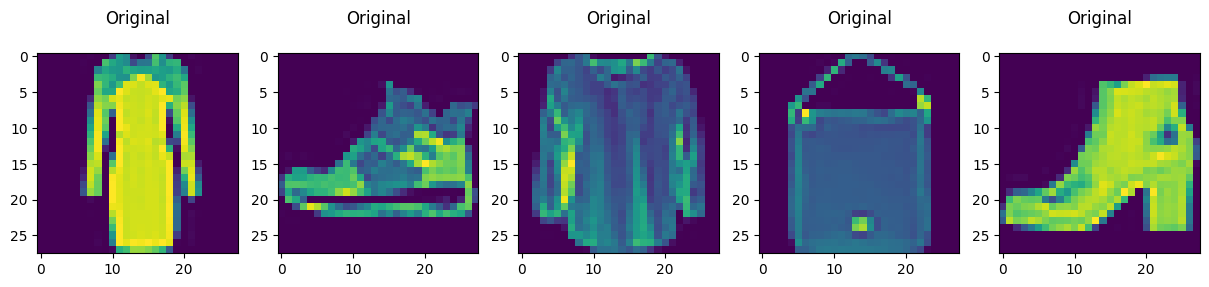

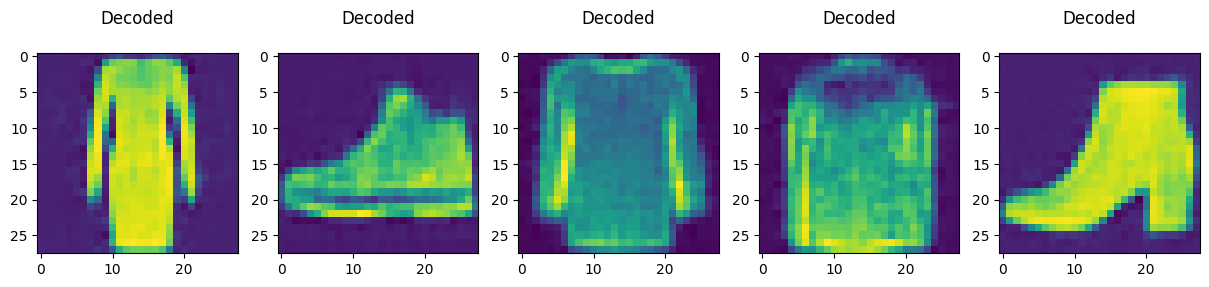

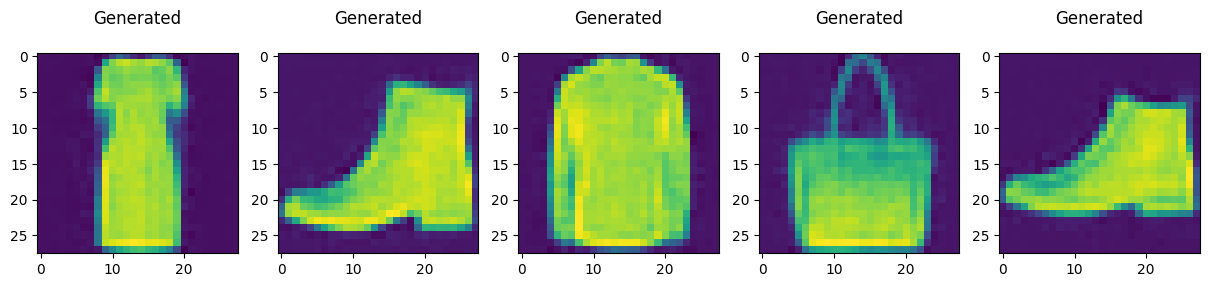

In [26]:
autoencoder.eval()
x, label_cond_x = next(iter(test_loader))
img_shape = [44,44]

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example = x[i:i+1]
    example = example.cpu().detach().numpy()
    example = example.squeeze()
    plt.imshow(example)
    plt.title("Original\n")
plt.show()

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    example,_ = autoencoder.forward(x[i:i+1].to(device))
    example = example.cpu().detach().numpy()
    example = example.squeeze()
    plt.imshow(example)
    plt.title("Decoded\n")
plt.show()

plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    y_onehot = torch.FloatTensor(batch_size, 10).to(device)
    y_onehot.zero_()
    cond_s = y_onehot.scatter_(1, label_cond_x.reshape([-1,1]), 1)
#     generated_noise = ng.forward(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    generated_noise = autoencoder.generate_noise(torch.rand(1, input_size).to(device),cond_s[i:i+1].to(device))
    example = autoencoder.generate(generated_noise)
    example = example.cpu().detach().numpy()
    example = example.squeeze()
#     example[example==0]=-0.1*example.max()
    plt.imshow(example)
    plt.title("Generated\n")
plt.show()

In [38]:
def generate_image(label):
    y_onehot = torch.FloatTensor(1, 10).to(device)
    y_onehot.zero_()
    y_onehot = y_onehot.scatter_(1, label.reshape([-1,1]), 1)
    generated_noise = autoencoder.generate_noise(
        torch.rand(1, input_size).to(device),
        y_onehot.to(device)
    )
    example = autoencoder.generate(generated_noise)
    example = example.cpu().detach().numpy()
    example = example.squeeze()
    return example, label

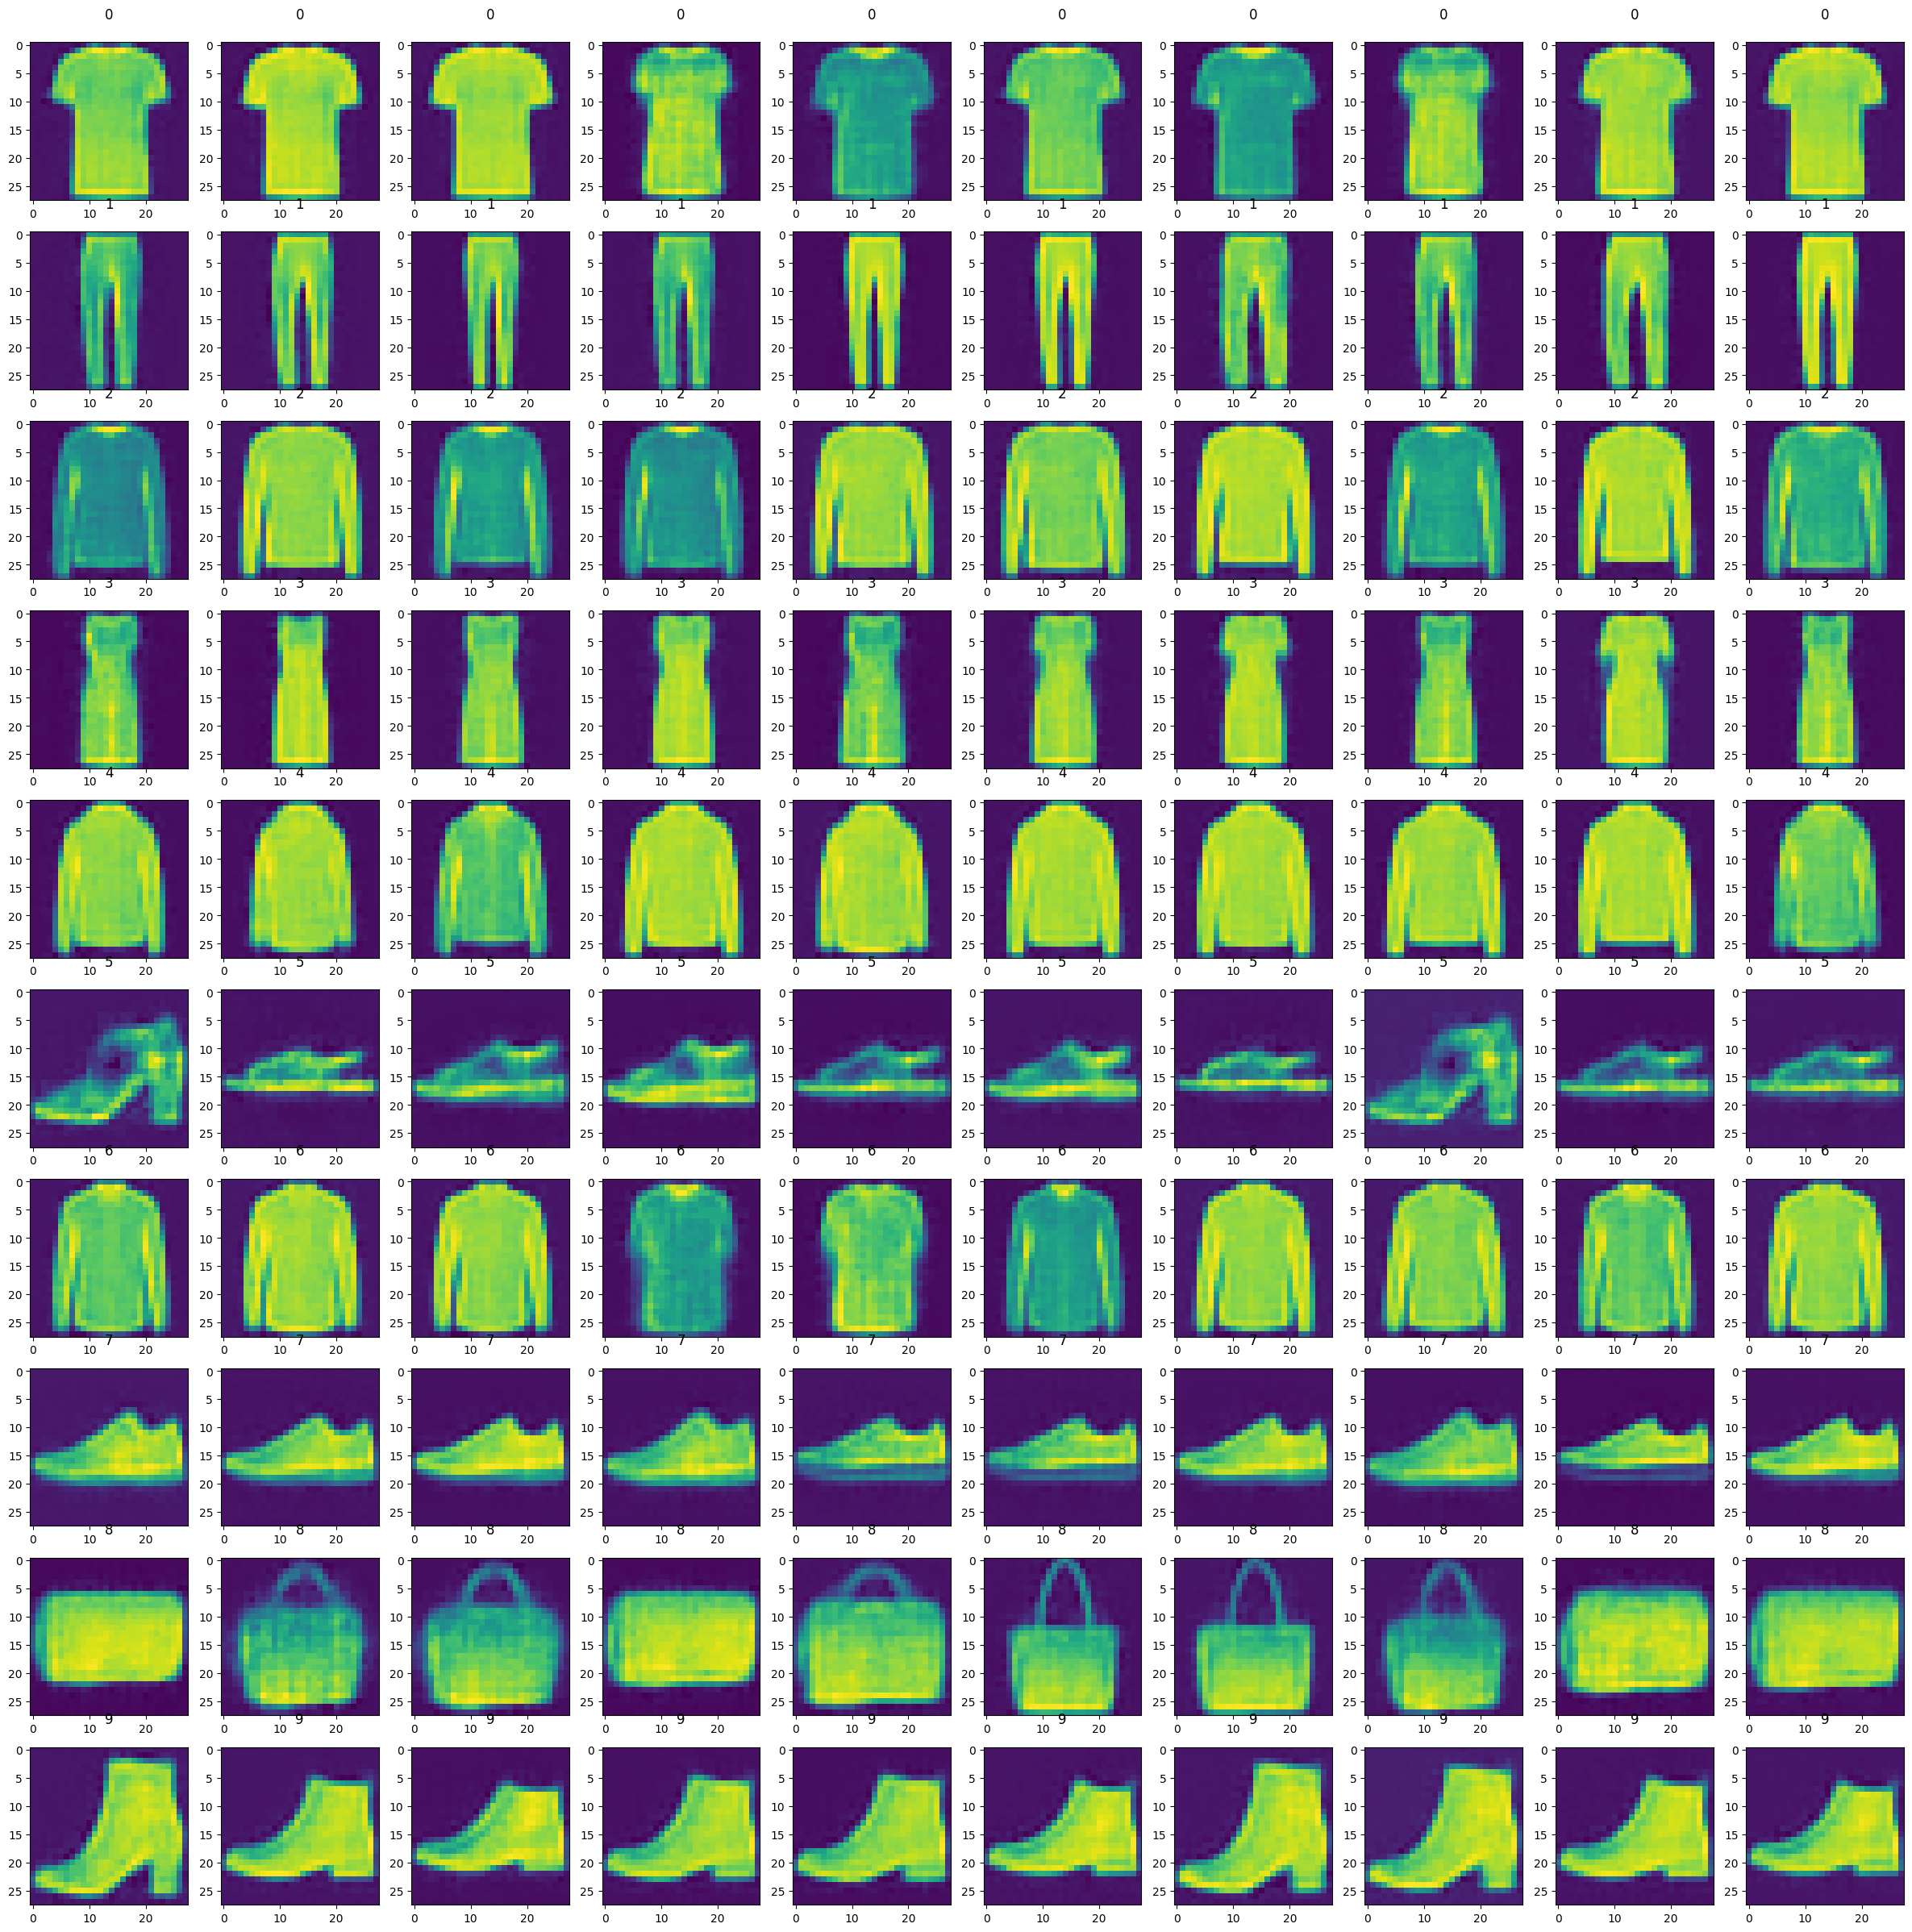

In [39]:
#generate 10 images for each of 10 classes 0..9
plt.figure(figsize=(30,30))
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        example, label = generate_image(torch.tensor([i]))
        plt.imshow(example)
        plt.title("{}\n".format(label.item()))

In [43]:
print(X_test.flatten(1).shape)

torch.Size([10000, 784])


In [44]:
#tsne on test data
import numpy
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

print(X_test.shape)
clean_representation = tsne.fit_transform(X_test.flatten(1))
latent_representation = tsne.fit_transform(autoencoder.forward(X_test)[1].cpu().detach().numpy())

torch.Size([10000, 1, 28, 28])
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 7.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.781756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.518814
[t-SNE] KL divergence after 300 iterations: 2.5

clean -> images as 784dim array -> TSNE
latent -> encode into 16dim -> TSNE 

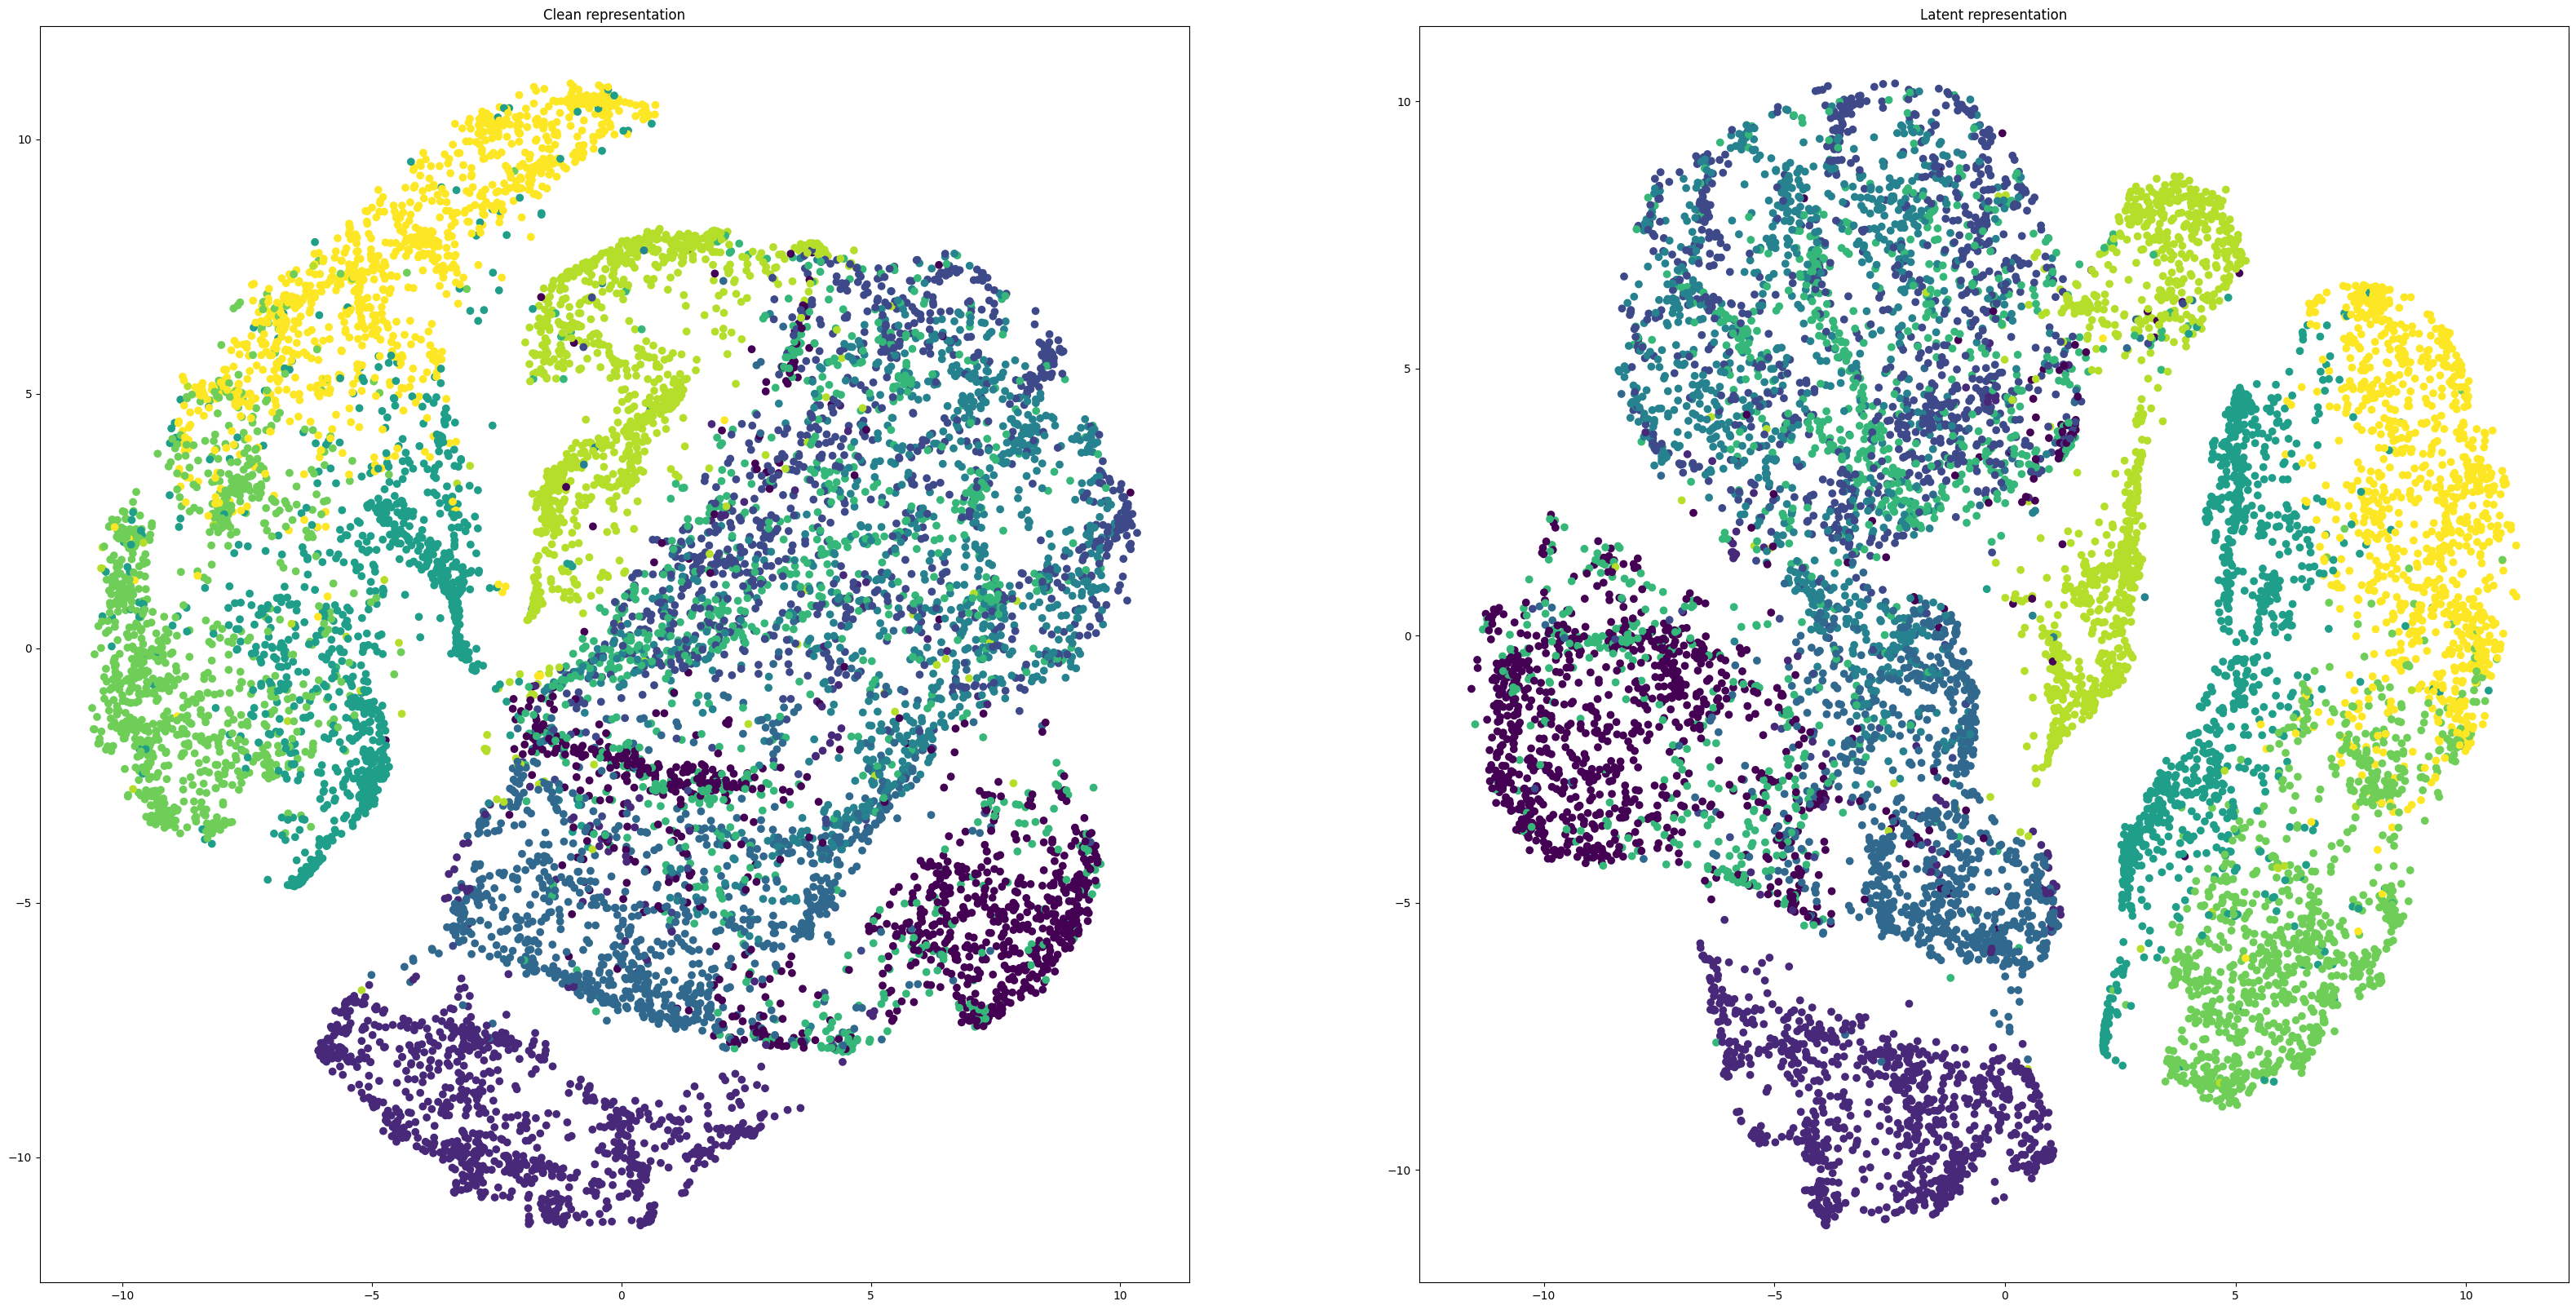

In [46]:
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.scatter(clean_representation[:,0], clean_representation[:,1], c=y_test.cpu().detach().numpy())
plt.title("Clean representation")
plt.subplot(1,2,2)
plt.scatter(latent_representation[:,0], latent_representation[:,1], c=y_test.cpu().detach().numpy())
plt.title("Latent representation")
plt.show()